# Lấy và unzip dữ liệu

In [1]:
!kaggle datasets download -d alexteboul/diabetes-health-indicators-dataset
!unzip /kaggle/working/diabetes-health-indicators-dataset.zip -d /kaggle/working/

Dataset URL: https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset
License(s): CC0-1.0
  0%|                                               | 0.00/6.03M [00:00<?, ?B/s]
100%|███████████████████████████████████████| 6.03M/6.03M [00:00<00:00, 210MB/s]
Archive:  /kaggle/working/diabetes-health-indicators-dataset.zip
  inflating: /kaggle/working/diabetes_012_health_indicators_BRFSS2015.csv  
  inflating: /kaggle/working/diabetes_binary_5050split_health_indicators_BRFSS2015.csv  
  inflating: /kaggle/working/diabetes_binary_health_indicators_BRFSS2015.csv  


# import thư viện và đọc, lọc và phân chia dữ liệu từ file csv

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV

In [3]:
features = pd.read_csv('/kaggle/working/diabetes_binary_5050split_health_indicators_BRFSS2015.csv')

# Preprocessing

In [4]:
# gộp
features.loc[features['Education'] < 3, 'Education'] = 3

In [5]:
print(len(features))
features.drop_duplicates(inplace=True)
features.reset_index(drop=True, inplace=True)
print(len(features))

70692
69055


In [6]:
# loại bỏ các dữ liệu trùng lặp
features.drop_duplicates(inplace=True)
features.reset_index(drop=True, inplace=True)
Sscaler = StandardScaler()
Rscaler = RobustScaler()
Mscaler = MinMaxScaler()
features_standardized = pd.DataFrame(Sscaler.fit_transform(features), columns=features.columns)
features_robust = pd.DataFrame(Rscaler.fit_transform(features), columns=features.columns)
features_MinMax = pd.DataFrame(Mscaler.fit_transform(features), columns=features.columns)



features[['BMI', 'Age', 'GenHlth']] = features_standardized[['BMI', 'Age', 'GenHlth']]
features[['MentHlth', 'PhysHlth']] = features_robust[['MentHlth', 'PhysHlth']]
features[['Education', 'Income']] = features_MinMax[['Education', 'Income']]


# Chia dữ liệu thành tập train-valid-test

In [7]:
class_0 = features[features['Diabetes_binary'] == 0]
class_1 = features[features['Diabetes_binary'] == 1]

x_class_0, y_class_0 = class_0.drop(columns=['Diabetes_binary'], axis=1), class_0['Diabetes_binary']
x_class_1, y_class_1 = class_1.drop(columns=['Diabetes_binary'], axis=1), class_1['Diabetes_binary']

x_0_train, x_0_test, y_0_train, y_0_test = train_test_split(x_class_0, y_class_0, test_size=0.2, random_state=1)
x_1_train, x_1_test, y_1_train, y_1_test = train_test_split(x_class_1, y_class_1, test_size=0.2, random_state=1)

x_0_train, x_0_val, y_0_train, y_0_val = train_test_split(x_0_train, y_0_train, test_size=0.25, random_state=1)
x_1_train, x_1_val, y_1_train, y_1_val = train_test_split(x_1_train, y_1_train, test_size=0.25, random_state=1)



x_train = pd.concat(objs=[x_0_train, x_1_train], ignore_index=True).to_numpy()
y_train = pd.concat(objs=[y_0_train, y_1_train], ignore_index=True).to_numpy()
index = np.arange(x_train.shape[0])
np.random.shuffle(index)
x_train = x_train[index]
y_train = y_train[index]

x_val = pd.concat(objs=[x_0_val, x_1_val], ignore_index=True).to_numpy()
y_val = pd.concat(objs=[y_0_val, y_1_val], ignore_index=True).to_numpy()
index = np.arange(x_val.shape[0])
np.random.shuffle(index)
x_val = x_val[index]
y_val = y_val[index]

x_test = pd.concat(objs=[x_0_test, x_1_test], ignore_index=True).to_numpy()
y_test = pd.concat(objs=[y_0_test, y_1_test], ignore_index=True).to_numpy()
index = np.arange(x_test.shape[0])
np.random.shuffle(index)
x_test = x_test[index]
y_test = y_test[index]

# Tìm tham số tốt nhất cho mô hình

In [8]:
# max_f1_score = {
#     'score': 0,
#     'penalty': '',
#     'l1_ratio': '',
#     'c': ''
# }

# max_accuracy_score = {
#     'score': 0,
#     'penalty': '',
#     'l1_ratio': '',
#     'c': ''
# }

# for penalty in ['l1', 'l2', 'elasticnet']:
#     if penalty == 'elasticnet':
#         for l1_ratio in range(1, 10):
#             for c_curr in [2, 1, 0.1, 0.01, 0.001]:
#                 f1_arr = []
#                 accuracy_arr = []
#                 c_arr = [];
#                 for i in range(100):
#                     model = LogisticRegression(penalty=penalty,solver='saga',C=c_curr - (99 - i) * c_curr/100, l1_ratio=l1_ratio/10)
#                     model.fit(x_train, y_train)
#                     y_pred = model.predict(x_val)
#                     c_arr.append(c_curr - (99 - i) * c_curr/100)
#                     f1_arr.append(f1_score(y_val, y_pred, average='macro'))
#                     accuracy_arr.append(accuracy_score(y_val, y_pred))
#                 if max_f1_score.get('score') < max(f1_arr):
#                     max_f1_score = {
#                         'score': max(f1_arr),
#                         'penalty': penalty,
#                         'l1_ratio': l1_ratio/10,
#                         'c': c_curr - (99 - f1_arr.index(max(f1_arr))) * c_curr / 100
#                     }
#                 if max_accuracy_score.get('score') < max(accuracy_arr):
#                     max_accuracy_score = {
#                         'score': max(accuracy_arr),
#                         'penalty': penalty,
#                         'l1_ratio': l1_ratio/10,
#                         'c': c_curr - (99 - accuracy_arr.index(max(accuracy_arr))) * c_curr / 100
#                     }
#                 fig = plt.figure(figsize=(15, 10))
#                 gs = gridspec.GridSpec(4, 2, width_ratios=[1, 1], wspace=0.3, hspace=0.5)  # Khoảng cách giữa các subplot

#                 ax1 = fig.add_subplot(gs[0])
#                 ax2 = fig.add_subplot(gs[1])
                
#                 ax1.set_title(f"penalty={penalty}, l1_ratio={l1_ratio/10}, c_curr={c_curr}")
#                 ax1.set_xlabel('C')
#                 ax1.set_ylabel('f1 score')
#                 ax1.plot(c_arr, f1_arr)
                
#                 ax2.set_title(f"penalty={penalty}, l1_ratio={l1_ratio/10}, c_curr={c_curr}")
#                 ax2.set_xlabel('C')
#                 ax2.set_ylabel('accuracy score')
#                 ax2.plot(c_arr, accuracy_arr)
#                 plt.show()
#     else:
#         for c_curr in [2, 1, 0.1, 0.01, 0.001]:
#             f1_arr = []
#             accuracy_arr = []
#             c_arr = [];
#             for i in range(100):
#                 model = LogisticRegression(penalty=penalty,solver='saga',C=c_curr - (99 - i) * c_curr/100)
#                 model.fit(x_train, y_train)
#                 y_pred = model.predict(x_val)
#                 c_arr.append(c_curr - (99 - i) * c_curr/100)
#                 f1_arr.append(f1_score(y_val, y_pred, average='macro'))
#                 accuracy_arr.append(accuracy_score(y_val, y_pred))
#             if max_f1_score.get('score') < max(f1_arr):
#                 max_f1_score = {
#                     'score': max(f1_arr),
#                     'penalty': penalty,
#                     'l1_ratio': None,
#                     'c': c_curr - (99 - f1_arr.index(max(f1_arr))) * c_curr / 100
#                 }
#             if max_accuracy_score.get('score') < max(accuracy_arr):
#                 max_accuracy_score = {
#                     'score': max(accuracy_arr),
#                     'penalty': penalty,
#                     'l1_ratio': None,
#                     'c': c_curr - (99 - accuracy_arr.index(max(accuracy_arr))) * c_curr / 100
#                 }
#             fig = plt.figure(figsize=(15, 10))
#             gs = gridspec.GridSpec(4, 2, width_ratios=[1, 1], wspace=0.3, hspace=0.5)  # Khoảng cách giữa các subplot

#             ax1 = fig.add_subplot(gs[0])
#             ax2 = fig.add_subplot(gs[1])
#             ax1.set_title(f"penalty={penalty}, c_curr={c_curr}")
#             ax1.set_xlabel('C')
#             ax1.set_ylabel('f1 score')
#             ax1.plot(c_arr, f1_arr)

#             ax2.set_title(f"penalty={penalty}, c_curr={c_curr}")
#             ax2.set_xlabel('C')
#             ax2.set_ylabel('accuracy score')
#             ax2.plot(c_arr, accuracy_arr)
#             plt.show()
# print("parameter for max f1 score train:", max_f1_score)
# print("parameter for max accuracy score train:", max_accuracy_score)

# Sử dụng gridSearchCV tìm tham số tốt nhất

In [9]:
model = LogisticRegression(random_state=42)
param_grid = {
    'C': [i/100 for i in range(201)],      
    'penalty': ['l1', 'l2', 'elasticnet'], 
    'solver': ['saga']    
}
grid_search = GridSearchCV(
    estimator=model,        
    param_grid=param_grid,  
    scoring='f1_macro',     
    cv=5,                   
    verbose=1,              
    n_jobs=-1            
)
grid_search.fit(x_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)
optimal = grid_search.best_params_

Fitting 5 folds for each of 603 candidates, totalling 3015 fits


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1015 fits failed out of a total of 3015.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1160, in fit
    self._validate_params()
  File "/opt/conda/lib/python3.10/site-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/opt/conda/lib/python3.10/site-packages/sk

Best parameters: {'C': 0.04, 'penalty': 'l2', 'solver': 'saga'}
Best score: 0.7411552569523924


In [10]:
x_train = np.append(x_train, x_val, axis = 0)
y_train = np.append(y_train, y_val)
model = LogisticRegression(penalty= optimal.get('penalty') , C=optimal.get('C'), solver=optimal.get('solver'))
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(accuracy_score(y_test, y_pred)) 
print(f1_score(y_test, y_pred, average='macro'))

0.7513576134964883
0.7510850717132768


# Đánh giá các cột quan trọng

In [11]:
featureColumn = []
means = []
std = []
perm_importance = permutation_importance(model, x_val, y_val, scoring='f1_macro', random_state=2, n_repeats=50)
for i in perm_importance.importances_mean.argsort()[::-1]:
    print(f"Feature {features.columns[i+1][:4]}, Importance: {perm_importance.importances_mean[i]:.4f} ± {perm_importance.importances_std[i]:.4f}")
    featureColumn.append(features.columns[i+1])
    means.append(perm_importance.importances_mean[i])
    std.append(perm_importance.importances_std[i])

Feature GenH, Importance: 0.0542 ± 0.0026
Feature BMI, Importance: 0.0298 ± 0.0020
Feature Age, Importance: 0.0232 ± 0.0027
Feature High, Importance: 0.0187 ± 0.0019
Feature High, Importance: 0.0093 ± 0.0015
Feature Chol, Importance: 0.0040 ± 0.0007
Feature Sex, Importance: 0.0032 ± 0.0012
Feature HvyA, Importance: 0.0025 ± 0.0007
Feature Hear, Importance: 0.0011 ± 0.0006
Feature Inco, Importance: 0.0009 ± 0.0009
Feature Stro, Importance: 0.0003 ± 0.0005
Feature Phys, Importance: 0.0003 ± 0.0008
Feature Vegg, Importance: 0.0002 ± 0.0003
Feature Phys, Importance: 0.0002 ± 0.0005
Feature Smok, Importance: 0.0001 ± 0.0001
Feature Diff, Importance: 0.0000 ± 0.0007
Feature NoDo, Importance: -0.0000 ± 0.0001
Feature AnyH, Importance: -0.0001 ± 0.0002
Feature Ment, Importance: -0.0003 ± 0.0005
Feature Educ, Importance: -0.0004 ± 0.0006
Feature Frui, Importance: -0.0005 ± 0.0005


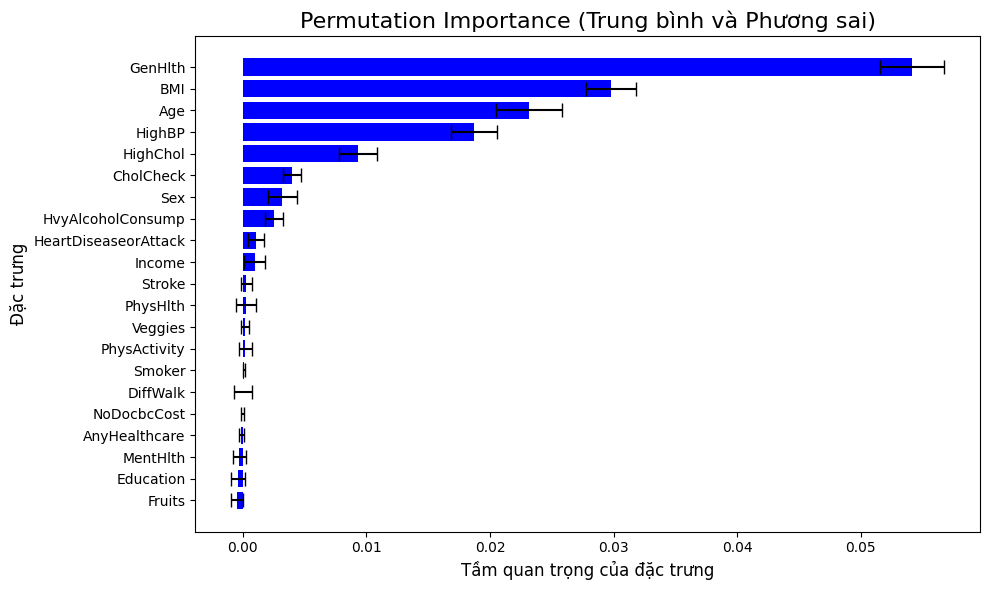

In [12]:
sorted_indices = np.argsort(means)
features_sorted = [featureColumn[i] for i in sorted_indices]
importance_sorted = [means[i] for i in sorted_indices]
std_sorted = [std[i] for i in sorted_indices]
plt.figure(figsize=(10, 6))
plt.barh(features_sorted, importance_sorted, xerr=std_sorted, color='blue', alpha=1, capsize=5)
plt.title("Permutation Importance (Trung bình và Phương sai)", fontsize=16)
plt.xlabel("Tầm quan trọng của đặc trưng", fontsize=12)
plt.ylabel("Đặc trưng", fontsize=12)
plt.tight_layout()
plt.show()

# Xóa các cột có importance âm

In [13]:
drop_columns = []
for index,value in enumerate(perm_importance.importances_mean):
    if value < 0:
    # if abs(perm_importance.importances_mean[index]) <= abs(perm_importance.importances_std[index]):
        drop_columns.append(features.columns[index+1])
print(drop_columns)
features = features.drop(columns=drop_columns, axis = 1)
print(features.columns)

['Fruits', 'AnyHealthcare', 'NoDocbcCost', 'MentHlth', 'Education']
Index(['Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Veggies',
       'HvyAlcoholConsump', 'GenHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age',
       'Income'],
      dtype='object')


# Chia dữ liệu thành tập train-test

In [14]:
class_0 = features[features['Diabetes_binary'] == 0]
class_1 = features[features['Diabetes_binary'] == 1]

x_class_0, y_class_0 = class_0.drop(columns=['Diabetes_binary'], axis=1), class_0['Diabetes_binary']
x_class_1, y_class_1 = class_1.drop(columns=['Diabetes_binary'], axis=1), class_1['Diabetes_binary']

x_0_train, x_0_test, y_0_train, y_0_test = train_test_split(x_class_0, y_class_0, test_size=0.2, random_state=1)
x_1_train, x_1_test, y_1_train, y_1_test = train_test_split(x_class_1, y_class_1, test_size=0.2, random_state=1)

x_train = pd.concat(objs=[x_0_train, x_1_train], ignore_index=True).to_numpy()
y_train = pd.concat(objs=[y_0_train, y_1_train], ignore_index=True).to_numpy()
index = np.arange(x_train.shape[0])
np.random.shuffle(index)
x_train = x_train[index]
y_train = y_train[index]

x_test = pd.concat(objs=[x_0_test, x_1_test], ignore_index=True).to_numpy()
y_test = pd.concat(objs=[y_0_test, y_1_test], ignore_index=True).to_numpy()
index = np.arange(x_test.shape[0])
np.random.shuffle(index)
x_test = x_test[index]
y_test = y_test[index]

# Train với tập train-test để tìm max f1 score

In [15]:
model = LogisticRegression(penalty= optimal.get('penalty') , C=optimal.get('C'), solver=optimal.get('solver'))
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average='macro'))

0.7501991166461516
0.7499204854637981
